# Self-Driving Car Engineer Nanodegree


## Project: **Finding Lane Lines on the Road** 
***
This jupyter notebook provides an interactive representation of the lane line detection pipeline applied to a series of individual images, and later applied to a video stream (really just a series of images). This notebook is meant to be interactive. For a more organized code implementation, commentary and writeup, see the [main repository](https://github.com/dcyoung/self-driving-car-ND-projects/tree/master/P1-LaneLines).

---

## Import Packages

In [3]:
#importing some useful packages
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
from moviepy.editor import VideoFileClip
import math
%matplotlib inline

## Read and Write an Image

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


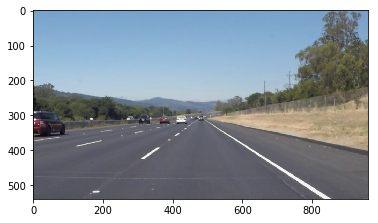

In [4]:
def read_image(filepath, bReadWithOpenCV=False):
    """ Reads an image from a file
    Args:
        The path to the image file
    Returns:
        image
    """
    if bReadWithOpenCV:
        return cv2.imread(filepath)
    return mpimg.imread(filepath)


def write_image(filepath, img, BGR=False):
    """ Writes an image to a file
    Args:
        filepath: Where to write the image
        img: The image to write
    """

    if BGR:
        rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        cv2.imwrite(filepath, rgb)
    else:
        cv2.imwrite(filepath, img)
    
#reading in an kimage
image = read_image('test_images/solidWhiteRight.jpg')

#printing out some stats and plotting
print('This image is:', type(image), 'with dimensions:', image.shape)
plt.imshow(image)  # if you wanted to show a single color channel image called 'gray', for example, call as plt.imshow(gray, cmap='gray')

## Elementary Line Segments

The following class and helper methods provide operations related to elementary line segments.

In [5]:
from sklearn.cluster import KMeans

class ESL:
    """ Elementary Line Segment """

    def __init__(self, x1, y1, x2, y2):
        """ Constructor """
        self.x1 = x1
        self.y1 = y1
        self.x2 = x2
        self.y2 = y2
        self.delta_x = self.x2 - self.x1
        if self.delta_x is 0:
            self.delta_x += np.finfo(float).eps
        self.delta_y = self.y2 - self.y1

    def get_slope(self):
        """ Computes the slope (m) from line equation y=mx+b """
        return self.delta_y / self.delta_x

    def get_bias(self):
        """ Computes the bias (b) from line equation y=mx+b """
        return self.y1 - self.get_slope() * self.x1

    def get_polar(self):
        """ Returns the polar representation of the line
        rho: closest distance from origin to the line.
        theta: angle away from horizontal
        """
        theta = math.atan2(self.delta_y, self.delta_x)
        rho = self.x1 * math.sin(theta) + self.y1 * math.cos(theta)
        return (rho, theta)


def get_average_x(segments):
    """ Returns the average x coordinate among the segments """
    x_avg = 0
    for e in segments:
        x_avg += (e.x1 + e.x2)
    return x_avg / (2 * len(segments))


def get_cluster_assignments(segments, num_clusters=2):
    """ Clusters the elementary line segments based on their polar form """
    num_segments = len(segments)
    polar_lines = np.empty((num_segments, 2))

    # Package the line's polar forms nicely in a 2d array
    for i, e in enumerate(segments):
        polar_lines[i, :] = e.get_polar()

    # Perform k-means clustering on the polar form with 2 clusters
    kmeans = KMeans(n_clusters=num_clusters, random_state=0).fit(polar_lines)
    return kmeans.labels_


def get_average_slope(segments):
    """ Averages the slope m (y = mx + b) among the segments """
    avg_slope = 0
    for e in segments:
        avg_slope += e.get_slope()
    return avg_slope / len(segments)


def get_average_bias(segments):
    """ Averages the bias b (y = mx + b) among the segments """
    avg_bias = 0
    for e in segments:
        avg_bias += e.get_bias()
    return avg_bias / len(segments)

## Helper Functions/Utils

Below are some general helper functions.

In [6]:

def blank_img(img):
    """ Creates a new blank image the same size as img
    Args:
        img: The image with the desired dimensions
    """
    return np.copy(img) * 0


def boolean_mask(img, mask):
    """ Applies the boolean mask to the image """
    masked = np.copy(img)
    if len(img.shape) is 2:
        masked[mask] = 0
    else:
        masked[mask] = [0, 0, 0]
    return masked


def color_threshold(img, rgb_min=[200, 200, 200], rgb_max=[255, 255, 255]):
    """ Returns an image thresholded by the color criteria """
    # Mask pixels below the threshold
    color_thresholds = (img[:, :, 0] < rgb_min[0]) | (img[:, :, 1] < rgb_min[1]) | (img[:, :, 2] < rgb_min[2]) | (
        img[:, :, 0] > rgb_max[0]) | (img[:, :, 1] > rgb_max[1]) | (img[:, :, 2] > rgb_max[2])
    return color_thresholds


def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)


def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)


def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)


def region_of_interest(img, vertices):
    """
    Applies an image mask.

    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    # defining a blank mask to start with
    mask = np.zeros_like(img)

    # defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255

    # filling pixels inside the polygon defined by "vertices" with the fill color
    cv2.fillPoly(mask, vertices, ignore_mask_color)

    # returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def divide_segments(segments):
    """ Divides the lines into two sets """
    cluster_assignments = get_cluster_assignments(segments, num_clusters=2)
    set_1 = []
    set_2 = []
    for i, seg in enumerate(segments):
        if np.equal(cluster_assignments[i], 0):
            set_1.append(seg)
        else:
            set_2.append(seg)

    # compare the average slope to determine which set of lines is on the left
    # return left first, right second
    return (set_1, set_2) if get_average_slope(set_1) > get_average_slope(set_2) else (set_2, set_1)


def remove_unlikely_candidates(segments):
    """ Returns a new list with unlikely candidates removed """
    survivors = []
    for e in segments:
        if abs(e.get_slope()) > 0.5 and abs(e.get_slope()) < 2.0:
            survivors.append(e)
    return survivors


def draw_lines(img, lines, color=[255, 0, 0], thickness=2, y_2=None):
    """
    NOTE: this is the function you might want to use as a starting point once you want to
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).

    Think about things like separating line segments by their
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of
    the lines and extrapolate to the top and bottom of the lane.

    This function draws `lines` with `color` and `thickness`.
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    if lines is None:
        return

    # for line in lines:
    #     for x1, y1, x2, y2 in line:
    #         cv2.line(img, (x1, y1), (x2, y2), color, thickness)
    # return
    # convert cv2 lines to esl segments
    segments = [ESL(x1, y1, x2, y2) for l in lines for x1, y1, x2, y2 in l]

    segments = remove_unlikely_candidates(segments)
    if len(segments) <= 1:
        return

    # group them into left and right sets
    left_set, right_set = divide_segments(segments)

    (height, _, _) = img.shape

    m_left = get_average_slope(left_set)
    m_right = get_average_slope(right_set)
    b_left = get_average_bias(left_set)
    b_right = get_average_bias(right_set)

    # Recall y=mx+b, so x = (y-b)/m
    y_1 = height
    if y_2 is None:
        y_2 = int(round(height * 3 / 5))

    if m_left == float("inf") or m_left == float("-inf") or b_left == float("inf") or b_left == float("-inf"):
        x1_left = int(round(get_average_x(left_set)))
        x2_left = x1_left
    else:
        x1_left = int(round((y_1 - b_left) / m_left))
        x2_left = int(round((y_2 - b_left) / m_left))
    if m_right == float("inf") or m_right == float("-inf") or b_right == float("inf") or b_right == float("-inf"):
        x1_right = int(round(get_average_x(right_set)))
        x2_right = x1_right
    else:
        x1_right = int(round((y_1 - b_right) / m_right))
        x2_right = int(round((y_2 - b_right) / m_right))

    col_left = [255, 0, 0]
    col_right = [0, 0, 255]
    cv2.line(img, (x1_left, y_1), (x2_left, y_2), col_left, thickness)
    cv2.line(img, (x1_right, y_1), (x2_right, y_2), col_right, thickness)


def hough_lines(img, rho=2, theta=np.pi / 180, threshold=15, min_line_len=40, max_line_gap=20):
    """ Detect lines in an image of edges
    Args:
        img: the output of a Canny transform.
        rho: distance resolution in pixels of the Hough grid
        theta: angular resolution in radians of the Hough grid
        threshold: min num of votes (intersections in Hough grid cell)
        min_line_len:  minimum number of pixels making up a line
        max_line_gap: maximum gap in pixels between connectable line segments

    Returns:
        an image with hough lines drawn
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array(
        []), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img


def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.

    `initial_img` should be the image before any processing.

    The result image is computed as follows (Python 3 supports math symbols):

    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    if len(initial_img.shape) is 2:
        initial_img = cv2.cvtColor(initial_img, cv2.COLOR_GRAY2RGB)
    return cv2.addWeighted(initial_img, α, img, β, λ)




## Test Images

The following code lists images in the directory "test_images".

In [7]:
import os
os.listdir("test_images/")

['solidWhiteCurve.jpg',
 'solidWhiteRight.jpg',
 'solidYellowCurve.jpg',
 'solidYellowCurve2.jpg',
 'solidYellowLeft.jpg',
 'whiteCarLaneSwitch.jpg']

## Build a Lane Finding Pipeline



The following code is a pipeline run on all test_images. The code makes copies into the `test_images_output` directory.

In [8]:
def lane_detection_pipeline(img):
    """ Detect lane lines in an input image.
    Args:
        img: The original unmodified input image.
    Returns:
        A new image with lines drawn.
    """
    # calculate shape
    (height, width, num_channels) = img.shape
    
    # create color masks
    white_mask = color_threshold(img, rgb_min=[150, 150, 150])
    yellow_mask = color_threshold(
        img, rgb_min=[150, 150, 0], rgb_max=[255, 255, 165])
    color_mask = white_mask & yellow_mask

    # convert image to gray scale
    gray = grayscale(img)

    # blur image with Gaussian smoothing
    blur = gaussian_blur(gray, 5)

    # Define our parameters for Canny and apply
    edges = canny(blur, 50, 150)

    # Only keep the portions that originally had white or yellow
    color_masked = boolean_mask(edges, color_mask)

    # mask everything but the region of interest
    vertices = np.array([[(0, height), (width * 6 / 13, height * 3 / 5),
                          (width * 7 / 13, height * 3 / 5), (width, height)]], dtype=np.int32)
    masked = region_of_interest(color_masked, vertices)

    # Apply Hough transform
    detected_lines = hough_lines(
        img=masked,
        rho=2,  # distance resolution in pixels of the Hough grid
        theta=np.pi / 180,  # angular resolution in radians of the Hough grid
        threshold=15,  # min num of votes (intersections in Hough grid cell)
        min_line_len=40,  # minimum number of pixels making up a line
        max_line_gap=20    # maximum gap in pixels between connectable line segments
    )

    # Overlay the detected lines on the original img
    output = weighted_img(detected_lines, img)

    return output


def run_image_test(input_dir, output_dir):
    """ Performs lane detection on the test images """
    # Create an output dir if necessary
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    # Read the input_files into a list
    filenames = os.listdir(input_dir)

    for img_file in filenames:
        # open image
        input_img = read_image(input_dir + img_file)
        # process image
        output_img = lane_detection_pipeline(input_img)
        # save the output image
        write_image(output_dir + img_file, output_img, BGR=True)
        

# Actually run the test
run_image_test("./test_images/", "./test_images_output/")

## Results

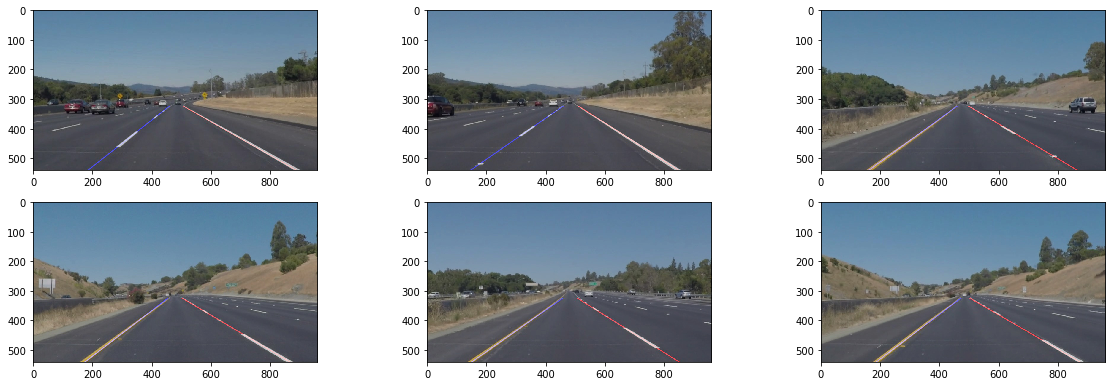

In [9]:
# Read the produced files into a list
output_dir = "./test_images_output/"
filenames = os.listdir(output_dir)
plt.figure(figsize=(20,10))
columns = 3
for i, img_file in enumerate(filenames):
    plt.subplot(len(filenames) / columns + 1, columns, i + 1)
    plt.imshow(read_image(output_dir + img_file))

## Test on Videos

Let's test the pipeline on a few videos (inlcuding a challenge video)!

In [10]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [12]:
def run_video_test(input_dir, output_dir):
    """ Performs lane detection on the test videos """
    # Create an output dir if necessary
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    # Read the input_files into a list
    filenames = os.listdir(input_dir)

    for video_file in filenames:
        input_file = input_dir + video_file
        output_file = output_dir + video_file
        # clip1 = VideoFileClip(input_file).subclip(0, 5)
        clip1 = VideoFileClip(input_file)
        output_clip = clip1.fl_image(lane_detection_pipeline)
        output_clip.write_videofile(output_file, audio=False)
#         %time output_clip.write_videofile(output_file, audio=False)
#         HTML("""<video width="960" height="540" controls><source src="{0}"></video>""".format(output_file))
        clip1.reader.close()
        clip1.audio.reader.close_proc()

# actually run the test        
run_video_test("./test_videos/", "./test_video_output/")

[MoviePy] >>>> Building video ./test_video_output/challenge.mp4
[MoviePy] Writing video ./test_video_output/challenge.mp4


100%|████████████████████████████████████████████████████████████████████████████████| 251/251 [00:10<00:00, 24.06it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./test_video_output/challenge.mp4 

[MoviePy] >>>> Building video ./test_video_output/solidWhiteRight.mp4
[MoviePy] Writing video ./test_video_output/solidWhiteRight.mp4


100%|███████████████████████████████████████████████████████████████████████████████▋| 221/222 [00:05<00:00, 39.89it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./test_video_output/solidWhiteRight.mp4 

[MoviePy] >>>> Building video ./test_video_output/solidYellowLeft.mp4
[MoviePy] Writing video ./test_video_output/solidYellowLeft.mp4


100%|███████████████████████████████████████████████████████████████████████████████▉| 681/682 [00:17<00:00, 37.88it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./test_video_output/solidYellowLeft.mp4 



Find the videos in your filesystem and play them in your video player of choice.